In [92]:
import pandas as pd
import os
import tarfile
from PIL import Image
import torchvision 
import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from datetime import datetime
import torch
import matplotlib.pyplot as plt
from torch import autograd
import math
import numpy as np

In [110]:
train_Set_Files=[]
test_Set_Files=[]

train_Sets=[]
test_Sets=[]
for i in range(1,6):
    s="tt\\"+str(i)+"-fold-train.csv"
    train_Set_Files.append(s)
    s="tt\\"+str(i)+"-fold-test.csv"
    test_Set_Files.append(s)
    
for i in range(len(train_Set_Files)):
    train_Set=pd.read_csv(train_Set_Files[i])
    test_Set=pd.read_csv(test_Set_Files[i])

    if "YEAR" in train_Set:
        train_Set.drop("YEAR", axis=1, inplace=True)
    if "YEAR" in test_Set:
        test_Set.drop("YEAR", axis=1, inplace=True)
    
    train_Sets.append(train_Set)
    test_Sets.append(test_Set)


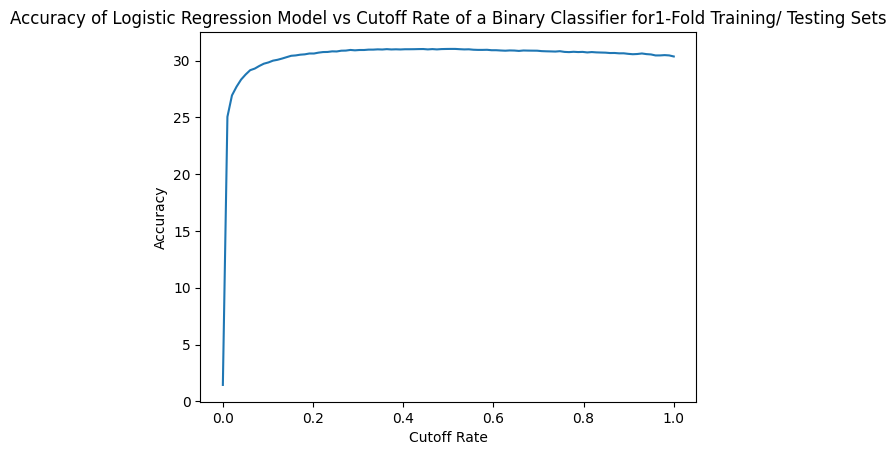

KeyboardInterrupt: 

In [113]:
#Logistic Regression:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        self.features = dataframe.drop('FlareNumber', axis=1).values
        self.targets = dataframe['FlareNumber'].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features = torch.tensor(self.features[idx], dtype=torch.float64)
        target = torch.tensor(self.targets[idx], dtype=torch.float64)
        return features, target
    
for i in range(len(train_Sets)):
    train_Set=train_Sets[i]
    test_Set=train_Sets[i]
    for col in train_Set:
        if col!="FlareNumber":
            max = train_Set[col].max()
            train_Set[col] = (train_Set[col])/max if max!=0 else 0
            test_Set[col] = (test_Set[col])/max if max!=0 else 0
            

    trainSet=CustomDataset(train_Set)
    testSet=CustomDataset(test_Set)

    train_Loader=DataLoader(trainSet, batch_size=32, shuffle=True)
    test_Loader=DataLoader(testSet, batch_size=32, shuffle=True)

    class LogisticRegression(nn.Module):
        def __init__(self, input_size):
            super(LogisticRegression, self).__init__()
            self.linear = nn.Sequential(       
                nn.Linear(input_size, input_size),
                nn.ReLU(),
                nn.Linear(input_size, 1),)

        def forward(self, x):
            out = self.linear(x)
            return out
        
        
    logReg=LogisticRegression(train_Set.shape[1]-1)
    logReg.double()
    loss_Function=nn.BCELoss()
    optimizer = torch.optim.Adam(logReg.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

    numEpochs=200

    logReg.train()

    loss_arr=[]
    for n in range(numEpochs):
        for inputs, labels in train_Loader:
            if(not torch.any(torch.isnan(inputs))):
                outputs = logReg(inputs).squeeze(1)
                optimizer.zero_grad()
                loss = loss_Function(torch.sigmoid(outputs), labels)
                loss.backward()
                loss_arr.append(loss.item())
                optimizer.step()
        scheduler.step()
        scheduler.step()

    logReg.eval()

    cutoff_arr=np.linspace(0, 1, 100)
    acc=[]
    for cutoff in cutoff_arr:
        count=1
        right=0
        for inputs,labels in test_Loader:
            if(not torch.any(torch.isnan(inputs))):
                    outputs = logReg(inputs).squeeze(1)
                    predicted_classes=torch.sigmoid(outputs)
                    loss=loss_Function(torch.sigmoid(outputs), labels)
                    for j in range(len(predicted_classes)):
                        if (predicted_classes[j].item())>cutoff and (labels[j].item())==1 or (predicted_classes[j].item())<cutoff and (labels[j].item())!=1:
                            right+=1
                    count+=1
        acc.append(right/count)


    plt.plot(cutoff_arr, acc, label=str(i+1)+"-fold")
    plt.xlabel("Cutoff Rate")
    plt.ylabel("Accuracy")
    plt.title("Accuracy of Logistic Regression Model vs Cutoff Rate of a Binary Classifier for" +str(i+1)+"-Fold Training/ Testing Sets")
    plt.show()
